# Best Fits in Python

Here, we will discuss how we generate "trendlines" like in Excel, except here we will do so with much more flexiblity utilizing the powerful package known as `lmfit`

## Linear regressions

Regression analysis is extremely important to experimental chemistry. Many measurement devices will return unitless values, signals, voltages, etc. through analog or digital outputs. It is then up to the experimentalist to be able to analyze that data, and calibrate it properly in order to extract the physical significance of any individual measurement.

Often, we might not initially know the quantitative relationship between the signal from the instrument and the physical quantity of interest, such as concentration. In this case, we can construct a **calibration curve**en, by varying the concentration in a known fasion and observing the resulting change in the observed signal. Calibration to known standards is the conceptual basis behind a host of experimental investigations in chemistry. Additionally, you are likely well-aware that linear best fits can allow us to determine the rate constants of first-order rate laws, so we will put this concept into practice here in Python.

To start, let's look at some of our previous data. In the "Manipulating Data" module, we imported and extracted data representing the peak emission intensity versus the integration time under laser excitation. Here, let's use that data to obtain a calibration curve for our emission intensity. Specifically, we'll extract the peak height from the data, and the integration time for the measurement from the filename, and plot these data as a scatter plot. just to see how it looks:

R101 532 ex 3.41 mW Integration 550CGLP 1000 ms.txt
R101 532 ex 3.41 mW Integration 550CGLP 20 ms.txt
R101 532 ex 3.41 mW Integration 550CGLP 200 ms.txt
R101 532 ex 3.41 mW Integration 550CGLP 2000 ms.txt
R101 532 ex 3.41 mW Integration 550CGLP 50 ms.txt
R101 532 ex 3.41 mW Integration 550CGLP 500 ms.txt
R101 532 ex 3.41 mW Integration 550CGLP 850 ms.txt


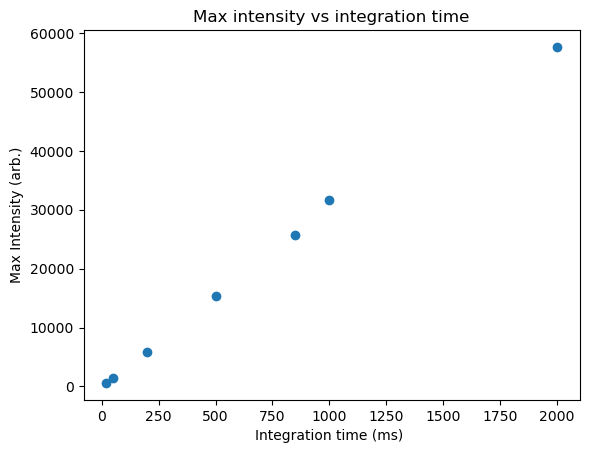

In [10]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Import data
max_array = []
inttime_array = []
for filename in os.listdir('data/em_vs_laser/'): #os.listdir() will return each file in a folder.
    wavelength, intensity = np.genfromtxt(f'data/em_vs_laser/{filename}',skip_header=14,delimiter='',unpack=True) # import the data from that file
    # extract the integration time from the filename
    if 'Integration' in filename:
        print(filename)
        inttime_array.append(filename.split(' ')[7]) #This extracts the integration time from the filename -- see the Importing Data section
        # truncate data to exclude possible laser peak
        intensity = intensity[(wavelength) > 575] # only fetch max from 575 nm and above, as laser peak is at 532 nm
        max_array.append(np.max(intensity))

# Re-format data
inttime_array = np.array(inttime_array) #Here, we cast the inttime_array (generated above) into a numpy array (rather than a generic 'list')
inttime_array = inttime_array.astype(np.float64) #Here, we cast the elements of the array to (numerical) float values. Recall that the filename was a string, so python was considering each element as a list of characters up until this step.
max_array = np.array(max_array) #We similarly cast the list of maximum intensities to a numpy array

# Plot data
plt.scatter(inttime_array,max_array)
plt.xlabel('Integration time (ms) ')
plt.ylabel('Max Intensity (arb.)')
plt.title('Max intensity vs integration time');

By inspection, the data is relatively linear. However, we can perform a linear fit to examine this more closely and determine the best-fitting parameters.

We will be using the `lmfit` package, which we can import by running the two following blocks of code seperately. 


`````{admonition} For CHM223 students
:class: alert
It is very important to run the following block code at least once to ensure that lmfit runs properly. Most online Jupyter services don't have lmfit built in, so we need to install it properly before we can utilize it. The following command will install lmfit into the environment, and the %%capture command will prevent the output from being displayed in the notebook. Importantly, the command must be run in a separate cell from the import statement to run properly.
`````

In [11]:
%%capture
pip install lmfit

In [12]:
# then, we can simply import the package as normal.
from lmfit import Model

Using **lmfit**, we can define the function we want to fit.

For a linear relation ($y=mx + b$), we can define our equation as

In [13]:
def best_fit(x,m,b):
    y = m*x + b # write our function here
    return y

Then, we can perform a best fit using some **initial parameters**

In [14]:
# define our model based on some input function
model = Model(best_fit)

# make a best fit of our data
result = model.fit(max_array, x=inttime_array, m = 30, b = 500) # intial guesses for m and b

print(result.fit_report())

[[Model]]
    Model(best_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 7
    # variables        = 2
    chi-square         = 6080061.21
    reduced chi-square = 1216012.24
    Akaike info crit   = 99.7223062
    Bayesian info crit = 99.6141265
    R-squared          = 0.99759140
[[Variables]]
    m:  29.1372245 +/- 0.64027826 (2.20%) (init = 30)
    b:  528.737569 +/- 593.542736 (112.26%) (init = 500)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, b) = -0.7120


Here, we can see all the statistical measures of our fit, which used to investigate and reference to see how well the fit actually performed. However, the parameters that give the best fit are presented in the **[[variables]]** part of the output. Speaking conceptually, we see that the y-intercept cannot be distinguished from zero, but the value of the slope is well-constrained.

We can also plot our best fit to visually compare it to our experimental data:

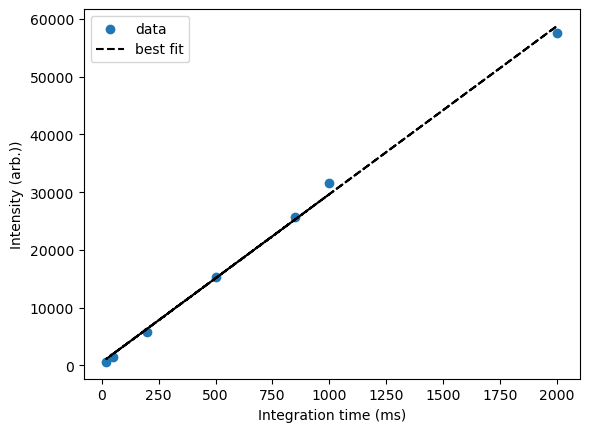

In [15]:
# plot out data on a logarithmic scale
plt.scatter(inttime_array,max_array,label = 'data')
# plot our best fit
plt.plot(inttime_array,result.best_fit, label = 'best fit', color = 'black', linestyle = '--')

# label our plot
plt.xlabel('Integration time (ms)')
plt.ylabel('Intensity (arb.))')
plt.legend();

What we observe is a qualitatively good fit, though it might be notable that the last data point is falling below the trend, which could herald a sub-linear response at large integration times. Further research could be required! 

Additionally, a powerful way to check the applicability of a fitting function is to calculate and plot the *residuals* for each data point---i.e. the degree to which each experimental value deviated from the value predicted by the best-fit model:

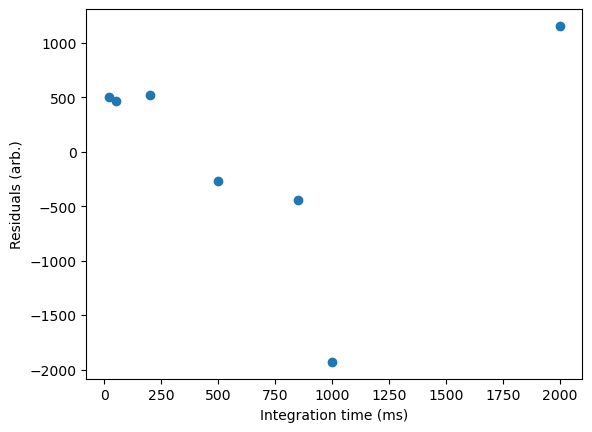

In [16]:
# plot the residuals
plt.scatter(inttime_array,result.residual,label = 'residuals')
plt.xlabel('Integration time (ms)')
plt.ylabel('Residuals (arb.)');

The residuals plot is very useful, as it allows us to see how good our fit is for various data points, and also tell us (much better than a r squared value!) how well our model actually fits our data. If a linear function correctly describes the relationship we are plotting, we expect the residuals to be randomly distributed. If there is some noticeable error, we will often see a pattern in our residuals. [You can find some examples of such here on the R4EnvChem notebook](https://uoftchem-teaching.github.io/R4EnvChem/modelling-linear-regression.html#vizualizing-residuals)

## Non-Linear Regressions

`````{admonition} For CHM223 students
:class: important
This subsection is relevant for your assignment!
`````

Linear regressions are useful, but these are usually straightforward to do in Excel (or by hand!), so you might ask 'what's new'? An advantage of python, and more specifically `lmfit` is that it can be used to fit to **non-linear models**, where the expected functional form varies from a simple linear relation. 

What do we mean by non-linear? Anything you could think of! Quadratic, exponential, power-law, gaussian, etc. 
To start, let's look at the hydrolysis data we plotted earlier to see if we can extract some quantities related to the rate law. We know that if the rate law is first order, taking the logarithm of the concentration over time will give us a linear trend, which we can then use to find the corresponding rate of reaction. However, with non-linear fitting, we can just simply fit the data directly to an exponential function instead!

Remember, for a first-order reaction, we expect the concentration over time to follow

$$
[\text{A}] = [\text{A}]_0 e^{-k t}
$$

Therefore, rather than taking the logarithm of our data, let's simply fit it to a (decaying) exponential function! 
Conceptually/programmatically, this is very similar to the linear example above, but pay close attention to where we define our fitting function (cleverly called `function`.) Here, it is a decaying exponential, but this could be any algebraic function that you can write.
We'll also highlight that most fitting routines work much better if they are provided with a reasonable 'guess' of the fitting values. These can be done manually after you inspect the data, or generated programatically from the data. (For instance, a good 'guess' for the value of the `A` parameter would be the intensity of the data at the first timepoint.) Note that fitting with functions that only have a couple parameters tends to be fairly robust, so the specific value of your initial 'guess' often only needs to have the correct sign and order-of-magnitude and it will work well.


[[Model]]
    Model(function)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 16
    # variables        = 2
    chi-square         = 6.4251e-10
    reduced chi-square = 4.5894e-11
    Akaike info crit   = -379.011555
    Bayesian info crit = -377.466377
    R-squared          = 0.99999045
[[Variables]]
    k:  0.00369876 +/- 6.1801e-06 (0.17%) (init = 0.1)
    A:  0.00554737 +/- 2.7270e-06 (0.05%) (init = 0.005)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, A) = +0.4661


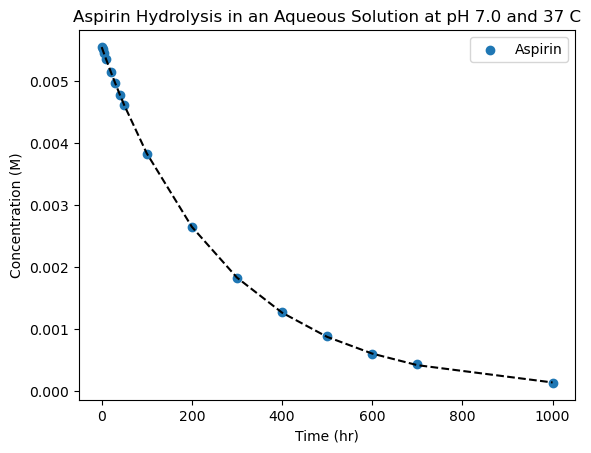

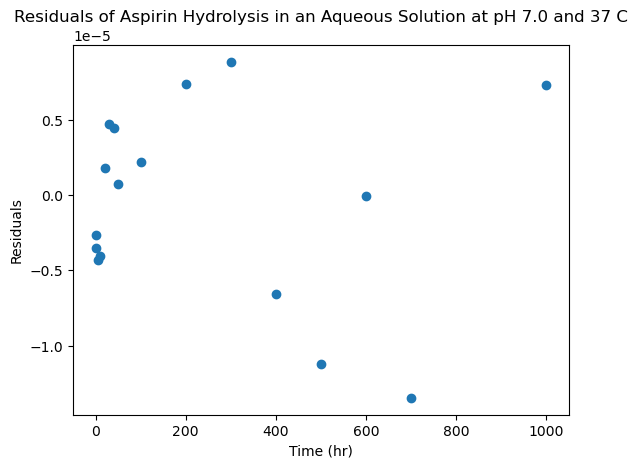

In [17]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lmfit import Model

time, conc_aspirin, conc_acid = np.genfromtxt('data/aspirin_data.txt',delimiter=',',skip_header=1,unpack=True)

# convert concentration to logarithmic scale
# plot our data and label
plt.scatter(time, conc_aspirin, label='Aspirin')

# label x and y axis
plt.xlabel('Time (hr)')
plt.ylabel('Concentration (M)')

# create plot title
plt.title('Aspirin Hydrolysis in an Aqueous Solution at pH 7.0 and 37 C')

# set y-axis to logarithmic scale
#plt.yscale('log')

# create legend
plt.legend()

# define fit function
def function(t,k,A):
    ### CHANGE YOUR FIT FUNCTION HERE ###
    y = A*np.exp(-k*t)
    return y

# define our model based on some input function
model = Model(function)

# make a best fit of our data
### CHANGE YOUR INITIAL GUESSES HERE ###
result = model.fit(conc_aspirin, t=time, k = 0.1, A = 0.005) # intial guesses for k and A 

print(result.fit_report())

# plot our best fit
plt.plot(time,result.best_fit, label = 'best fit', color = 'black', linestyle = '--')

# and create a plot of the residuals!
fig = plt.figure() # create a new figure

plt.scatter(time,result.residual,label = 'residuals')
plt.xlabel('Time (hr)')
plt.ylabel('Residuals')
plt.title('Residuals of Aspirin Hydrolysis in an Aqueous Solution at pH 7.0 and 37 C');

Success! By inspection, it looks like our data is very well captured by a decaying exponential, and the expontial time-constant ($	au=1/k$) rate-constant is about 270 hours, which looks reasonable by inspection.

Thus, we've been able to directly determine the initial concentration and the rate constant, without needing to do ANY preliminary transformations to the data. Now, in this simple example, either a non-linear regression directly on the data, or a linear regression on the logarithm of the data will be similarly effective. However, the two methods have differeing strengths and weaknesses, so they can be used complementarily.

Non-linear fitting is extremely powerful, because the possibilities for model functions are endless. We've only shown one simpler example here, but you can use any functional form to fit any data that you need. [Check out this page for an interactive module utilizing lmfit with robust function selection](https://github.com/wholden/jupyter-lmfit), or the [source documentation outlining examples of built in functional forms you can use](https://lmfit.github.io/lmfit-py/builtin_models.html)

## The reality of non-linear fits: Models and Data

It is important to acknowledge that when it comes to non-linear fits, it is very (dangerously?) easy to find a functional that gives a 'great-looking' fit to your data for some set of best-fit parameters. However, without further analysis, this is only a parametization of your experimental data---a mathematical function which happens to line up with the trends in your dataset. This is because regression analysis by itself only tells you the best-fit values of the parameters, given the functional form of the model that you used.  It is up to you as a scientist to determine whether the particular mathematical relationship has physical significance---a strong test of which is whether the function does well when extrapolated outside of the existing range. This usually needs a meaningful interplay of theory and experiments to justify the signifiance of a particular functional form and the coefficients.

For example, quantum dots are semiconducting nanocrystals a few nanometers in diameter that have size-tuneable absorption energies/wavelengths due to quantum confinement. In other words, if we tune our syntheses to make quantum dots from the same material but of a different (average) size, their excitonic absorption peack can be tuned across the visible spectrum. This relationship is useful to know, so that we could infer the physical size of a sample from its optical absorption peak. Indeed, researchers (Yu and co-workers) performed many syntheses, mesaured sizes by TEM, took spectra, and generated best-fit polynomial equations for nanocrystals in the cadmium chalchogenide family in a paper published in 2003.

```{figure} images/yu_QD_sizecurve.png
---
width: 600px
---
Adapted from Yu, W. et al (2003). Experimental determination of the extinction coefficient of CdTe, CdSe, and CdS nanocrystals. Chemistry of materials, 15(14), 2854-2860.
```
```{figure} images/yu_QD_sizecurve_eqns.png
---
width: 600px
---
Adapted from Yu, W. et al (2003). Experimental determination of the extinction coefficient of CdTe, CdSe, and CdS nanocrystals. Chemistry of materials, 15(14), 2854-2860.
```

This parametrization is a useful, as (within this range) it allows us to estimate the size of the quantum dots from their absorption spectra alone and vice versa. But, the authors include a very important paragraph, just below these equations in the source material

> "*In the above equations, D (nm) is the size of a given nanocrystal sample, and λ (nm) is the wavelength of the first  excitonic  absorption  peak  of  the  corresponding sample. **It  must  be  pointed  out  that  the  functions provided above are only polynomial fitting functions of the experimental data, which may become invalid in the size ranges not covered by the data shown in Figure 2.***"

While the fit function does a good job of tracking a trend through the data that is input, all it shows is just that---there is a trend in *this specific range of data.* For larger or smaller sizes, there is no guarantee that the 'model' will continue to work---indeed, polynomial fits often fail spectacularly when extrapolating. This is because **there is absolutely nothing 'physical' about the equations above**---no underlying theoretical model that implies that this is *the* functional form that best describes the size evolution of quantum dots. (And, indeed, one could do quite well with a particle-in-a-sphere!) Accordingly, though this best fit does provide a useful tool, it's important to remember the limits in generalizing from empirical fits to data.